In [1]:
import splat
import wisps
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm


%matplotlib inline

In [2]:
#plot mag vs 
obs=pd.read_csv(wisps.OUTPUT_FILES+'/observation_log.csv')
obs.columns=[x.lower() for x in obs.columns]#.lower()
def add_survey(pointing):
    if pointing.startswith('par'):
        return 'wisps'
    else:
        return '3d-hst'
obs_df=obs.drop(['unnamed: 0'], axis=1).drop_duplicates('pointing').reset_index()
obs_df['survey']=obs.pointing.apply(add_survey)

In [3]:
obs_df=obs_df.drop(['index'], axis=1)

In [4]:
#obs_df.to_latex(wisps.LIBRARIES+'/observations.tex', longtable=True, index=False)

In [5]:
phot=pd.read_hdf(wisps.LIBRARIES+'/master_dataset.hdf',  key='new')
fphot=wisps.Annotator.reformat_table(phot)

In [6]:
stars=wisps.Annotator.reformat_table(phot[phot.class_star !=0 ]).reset_index(drop=True)

In [7]:
stars=stars[stars.snr1>=3.0]

In [8]:
len(stars)

45344

In [9]:
cutphot=fphot[((fphot.snr1>=3.0))]

In [10]:
import astropy.stats.bayesian_blocks as bb

In [11]:
#edgesf160 =bb(cutphot.F160.replace(np.inf, np.nan).dropna(), fitness='events', p0=0.01)
#edges140= bb(cutphot.F140.replace(np.inf, np.nan).dropna(), fitness='events', p0=0.01)
#edges110= bb(cutphot.F110.replace(np.inf, np.nan).dropna(), fitness='events', p0=0.01)

In [12]:
wispsph=fphot[fphot.grism_id.str.startswith('par')]
hst3d=fphot[~ fphot.grism_id.str.startswith('par')]

In [13]:
len(phot), len(wispsph), len(hst3d), len(stars),len(stars[stars.snr1>3.])

(254264, 178856, 75408, 45344, 45344)

In [14]:
starswisp=stars[stars.grism_id.str.startswith('par')]
#starshst3d=stars[(~ stars.grism_id.str.startswith('par')) & (stars.star_flags !=2.) ]
starshst3d=stars[(~ stars.grism_id.str.startswith('par')) &  (stars.F160<25.)]
#starshst3d=stars[(~ stars.grism_id.str.startswith('par'))]

In [15]:
#stars.F160<25.

In [16]:
from matplotlib.ticker import MultipleLocator

In [17]:
wispsph.F160.dropna().values

array([25.763, 27.4  , 24.526, ..., 22.011, 24.726, 21.622])

In [18]:
from scipy import stats

https://rmflight.github.io/post/finding-modes-using-kernel-density-estimates/

In [19]:
kde_l_mags={}

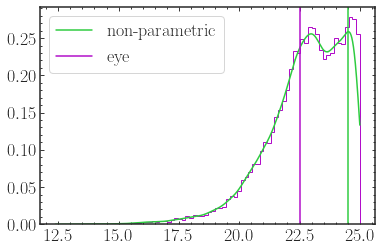

In [20]:
values=np.sort(starshst3d.F160.dropna().values)
kernel = stats.gaussian_kde(values)
height = kernel.pdf(values)
mode_value = values[np.argmax(height)]

plt.plot(values, height, color='#2ECC40', label='non-parametric')
plt.axvline(mode_value, color='#2ECC40')
plt.axvline(22.5,  color='#B10DC9', label='eye')
h=plt.hist(values,   bins='auto', color='#B10DC9', density=True, histtype='step')
plt.legend(fontsize=18)
plt.minorticks_on()

In [21]:
mode_value

24.526538137168664

In [22]:
#for k in ['F160', 'F140', 'F110']:
#    values=
    

In [23]:
kernel = stats.gaussian_kde(values)
height = kernel.pdf(values)
mode_value = values[np.argmax(height)]
print(mode_value)

24.526538137168664


In [24]:
mag_limits={'wisps':{'F110W':[22.5, 18.0], 'F140W':[22., 16.0], 'F160W':[22.0, 16.0] }, 
            'hst3d':{'F140W':[23., 16.0], 'F160W':[23., 16.0] }}

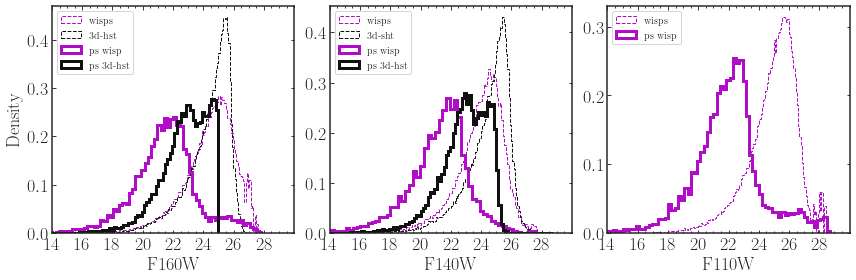

In [35]:
fig, ax=plt.subplots(ncols=3, figsize=(12, 4))
##top
h=ax[0].hist(wispsph.F160.dropna().values, label='wisps', bins='auto', color='#B10DC9', density=True, histtype='step', linestyle='--')
h=ax[2].hist(wispsph.F110.dropna().values,  label='wisps', bins='auto', color='#B10DC9', density=True, histtype='step', linestyle='--')
h=ax[1].hist(wispsph.F140.replace(np.inf, np.nan).dropna().values,   label='wisps', bins='auto', color='#B10DC9', density=True, histtype='step' , linestyle='--')
#h=cutphot.F140.replace(np.inf, np.nan).dropna().plot(kind='hist', ax=ax[0][2], bins='auto',label='F140', color='#7FDBFF', density=True)

h=ax[0].hist(hst3d.F160.dropna().values,  label='3d-hst', bins='auto', color='#111111', density=True, histtype='step', linestyle='--')
#h=ax[2].hist(hst3d.F110.dropna().values,  label='3d-hst', bins='auto', color='#2ECC40', density=True, histtype='step',  linestyle='--')
h=ax[1].hist(hst3d.F140.replace(np.inf, np.nan).dropna().values,  label='3d-sht', bins='auto', color='#111111', density=True, histtype='step',  linestyle='--')

h=ax[0].hist(starswisp.F160.dropna().values,  label='ps wisp', bins='auto', color='#B10DC9', density=True, linewidth=3, histtype='step')
h=ax[2].hist(starswisp.F110.dropna().values,   label='ps wisp', bins='auto', color='#B10DC9', density=True, linewidth=3,histtype='step')
h=ax[1].hist(starswisp.F140.replace(np.inf, np.nan).dropna().values,   label='ps wisp', bins='auto',  color='#B10DC9', linewidth=3,density=True, histtype='step')

h=ax[0].hist(starshst3d.F160.dropna().values,  label='ps 3d-hst', bins='auto', color='#111111', linewidth=3,density=True, histtype='step')
#h=ax[2].hist(starshst3d.F110.dropna().values,   label='ps 3d-hst', bins='auto', color='#111111', density=True, histtype='step')
h=ax[1].hist(starshst3d.F140.replace(np.inf, np.nan).dropna().values,   label='ps 3d-hst', bins='auto', linewidth=3, color='#111111', density=True, histtype='step')


#bayesian blocks
#H2 = ax[0][0].hist(cutphot.F160.replace(np.inf, np.nan).dropna(), bins=edgesf160, color='#111111',  density=True, lw =2, histtype='step')
#H2 = ax[0][1].hist(cutphot.F110.replace(np.inf, np.nan).dropna(), bins=edges110, color='#111111',  density=True, lw =2, histtype='step')
#H2 =ax[0][2].hist(cutphot.F140.replace(np.inf, np.nan).dropna(), bins=edges140, color='#111111',  density=True, lw =2, histtype='step')

#ax[0].axvline(mag_limits['wisps']['F140W'][0], color='#B10DC9', linestyle='-')
#ax[0].axvline(mag_limits['hst3d']['F140W'][0], color='#111111', linestyle='-')

#ax[2].axvline(mag_limits['wisps']['F110W'][0], color='#B10DC9', linestyle='-')
#ax[0][1].axvline(23,  color='#111111')


#ax[1].axvline(mag_limits['wisps']['F160W'][0],color='#B10DC9', linestyle='-')
#ax[1].axvline(mag_limits['hst3d']['F160W'][0], color='#111111', linestyle='-')





#ax[1][0].scatter( cutphot.F160, cutphot.exposure, marker=',', alpha=0.1, s=50)
#sns.kdeplot( cutphot.F160, cutphot.exposure, ax=ax[1][0])
#df=cutphot[['F160', 'exposure']].replace(np.inf, np.nan).dropna()
#ax[1][0].hist2d(df.F160.values, df.exposure.values, cmap=wisps.MYCOLORMAP)

#df=cutphot[['F110', 'exposure']].replace(np.inf, np.nan).dropna()
#ax[1][2].hist2d(df.F110.values, df.exposure.values, cmap=wisps.MYCOLORMAP)

#df=cutphot[['F140', 'exposure']].replace(np.inf, np.nan).dropna()
#ax[1][1].hist2d(df.F140.values, df.exposure.values, cmap=wisps.MYCOLORMAP)

#sns.kdeplot( df.F160, df.exposure, ax=ax[1][0], shade=True)
#ax[1][1].scatter( cutphot.F110, cutphot.exposure, marker=',', alpha=0.1, s=50)
#ax[1][2].scatter( cutphot.F140, cutphot.exposure, marker=',', alpha=0.1, s=50)



ax[0].set_xlabel('F160W', fontsize=18)
ax[2].set_xlabel('F110W', fontsize=18)
ax[1].set_xlabel('F140W', fontsize=18)

#ax[1][0].set_ylabel('Exposure (s)', fontsize=18)
ax[0].set_ylabel('Density', fontsize=18)
#ax[1][2].set_ylabel('Exposure (s)', fontsize=18)

for a in ax:
    a.set_xticks(np.arange(14, 30, 2.0))
    a.set_xlim([14, 30])
    a.yaxis.set_ticks_position('both')
    a.xaxis.set_ticks_position('both')
    a.xaxis.set_minor_locator
    #a.tick_params(which='major',direction='inout')
    a.tick_params(which='minor', direction='in')
    ml = MultipleLocator(.5)
    a.xaxis.set_minor_locator(ml)


#ax[0][0].set_ylim([0., 0.35])
#ax[0][1].set_ylim([0., 0.30])
#ax[0][2].set_ylim([0., 0.35])


ax[0].legend(loc='upper left', fontsize=10)
ax[1].legend(loc='upper left', fontsize=10)
ax[2].legend(loc='upper left', fontsize=10)
    
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/mag_limits_all.pdf', bbox_inches='tight')


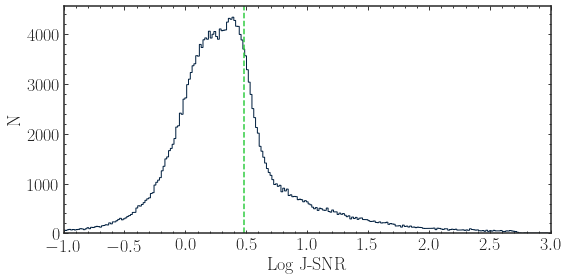

In [26]:
fig, ax1=plt.subplots(figsize=(8, 4), ncols=1, sharey=False)
#h=ax.hist(phot.f_test, bins='auto', color='#001f3f', density=False, histtype='step')

#ax.axvline(.4, color='#2ECC40', linestyle='--')
#ax.set_xlabel('F(x)', fontsize=18)
#ax.set_ylabel('N', fontsize=18)
#ax.minorticks_on()


h=ax1.hist(phot.snr1.apply(np.log10), bins='auto', color='#001f3f', density=False, histtype='step')

ax1.axvline(np.log10(3.), color='#2ECC40', linestyle='--')
ax1.set_xlabel('Log J-SNR', fontsize=18)
ax1.set_ylabel('N', fontsize=18)
ax1.set_xlim([-1., 3.])

ax1.minorticks_on()
plt.tight_layout()

plt.savefig(wisps.OUTPUT_FIGURES+'/f_test_snr_distr.pdf')

In [39]:
#MAKE MAGNITUDE LIMIT POLYNOMIALS HERE

In [27]:
def get_max_value(values):
    values=wisps.drop_nan(values)
    if len(values)<1:
        return np.nan
    if  np.equal.reduce(values):
        return  values.mean()
    if (len(values)>1) and (~np.equal.reduce(values)):
        kernel = wisps.kernel_density(values)
        height = kernel.pdf(values)
        mode_value = values[np.argmax(height)]
        return float(mode_value)

def get_polynomials(survey):
    exposure_times=[]
    mags=[]
    df=None
    
    if survey=='wisps': df= wisps.Annotator.reformat_table(starswisp)
    if survey=='hst3d': 
        df= wisps.Annotator.reformat_table(starshst3d)
    for g in df.groupby('pointing'):
        if len(g[1]) < 50:
            pass
        else:
            exposure_times.append(g[1].exposure_time.values.mean())
            mags.append([get_max_value(g[1].F110.values), get_max_value(g[1].F140.values), get_max_value(g[1].F160.values)])
            
    mags=np.vstack(mags)
    if survey=='hst3d': 
        p0=None
    else:
        p0=wisps.fit_polynomial(np.log10(exposure_times),  mags[:, 0], sigma_clip=True, sigma=5, n=1)
    p1=wisps.fit_polynomial(np.log10(exposure_times), mags[:, 1], sigma_clip=True, sigma=5, n=1)
    p2=wisps.fit_polynomial(np.log10(exposure_times),  mags[:, 2], sigma_clip=True, sigma=5, n=1)
    return {survey: {"F110":(p0, np.nanstd(mags[:,0])), "F140": (p1, np.nanstd(mags[:,1])), "F160":(p2, np.nanstd(mags[:,2]))}}


In [28]:
#fit a line to exposure times
wisppol= get_polynomials('wisps')
hst3dpol= get_polynomials('hst3d')

In [36]:
z = {**wisppol, **hst3dpol, 'ncutoff':50}

In [30]:
z

{'wisps': {'F110': (poly1d([ 1.58332072, 16.55679476]), 0.5038943667884174),
  'F140': (poly1d([ 1.55165028, 15.97456775]), 0.7495636144809823),
  'F160': (poly1d([ 0.32381253, 20.32498832]), 1.4165037712823727)},
 'hst3d': {'F110': (None, nan),
  'F140': (poly1d([ 0.3353958 , 21.64429535]), 0.18353856592257553),
  'F160': (poly1d([ 0.38991196, 21.33841198]), 0.1840187995673484)}}

In [38]:
import pickle
#save the random forest
output_file=wisps.OUTPUT_FILES+'/magnitude_cutoff.pkl'
with open(output_file, 'wb') as file:
    pickle.dump(z,file)


In [40]:
#VERIFY 

In [47]:
dfn=wisps.Annotator.reformat_table(stars)
dfng= stars.groupby('pointing')
mags_pers=[x[1].F140.median() for x in dfng]
exps=[x[1].exposure_time.median() for x in dfng]

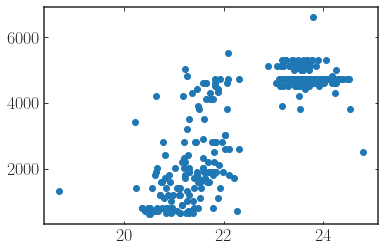

In [50]:
plt.scatter(mags_pers, exps)

In [ ]:
#scal=fits.open('https://urldefense.com/v3/__http://homepages.spa.umn.edu/*mscarlat/WISPPhotometricCatalog_v1.2.fits__;fg!!Mih3wA!V4jOw3ITlkzp1jvdGyu3fXDBgLCi8r-HtAKdSNKE66P5ojZq6a8aHNcZOde7Y84$')

In [ ]:
#def grism_id(row): return 'par'+ str(int(row.PAR))+'-'+ str(int(row.OBJ)).zfill(5)
#tbl=Table(scal[1].data)
#tbl_df=(tbl['RA', 'DEC', 'PAR','OBJ', 'MAG_AUTO_F140W']).to_pandas()
#tbl_df['grism_id']=tbl_df.apply(grism_id, axis=1)
#merged=tbl_df.merge(fphot, on='grism_id')
#merged.columns
#plt.plot(merged.F140, merged.MAG_AUTO_F140W)